# Bank Marketing Campaighn, Classification Task

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import recall_score
import time

# Load and clean the data

In [2]:
bank = pd.read_csv("C:/Users/micls/OneDrive/Desktop/UC Berkelely AI CLASS/data/bankDATA.csv")

In [3]:
bank.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no


In [4]:
#DROP UNKNOWN job,education,contact col, poutcome col 
#OHE default,education  
#BINARY housing, loan ,y, default 
#quantify month, education  

In [5]:
bank = bank.drop('contact', axis = 1)
bank = bank.drop('poutcome', axis = 1)

In [6]:
bank = bank[bank.job != 'unknown']
bank = bank[bank.education != 'unknown']

In [7]:
d = {'jan':1, 'feb':2, 'mar':3, 'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
bank.month = bank.month.map(d)
d = {'primary':1,'secondary':2,'tertiary':3}
bank.education = bank.education.map(d)

In [8]:
d = {'no':0,'yes':1}
bank.default = bank.default.map(d)
bank.housing = bank.housing.map(d)
bank.loan = bank.loan.map(d)
bank.y = bank.y.map(d)

In [9]:
dummies = pd.get_dummies(bank['job'])
bank = pd.concat([bank, dummies], axis=1)
dummies = pd.get_dummies(bank['marital'])
bank = pd.concat([bank,dummies],axis =1)
bank = bank.drop(['job','marital'],axis =1)

In [10]:
bank.head(3)

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,management,retired,self-employed,services,student,technician,unemployed,divorced,married,single
0,30,1,0,1787,0,0,19,10,79,1,...,0,0,0,0,0,0,1,0,1,0
1,33,2,0,4789,1,1,11,5,220,1,...,0,0,0,1,0,0,0,0,1,0
2,35,3,0,1350,1,0,16,4,185,1,...,1,0,0,0,0,0,0,0,0,1


# Train Test Split Data

In [11]:
X = bank.drop(['y'], axis =1)
y = bank['y']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 42)

# Logistic Regression

In [12]:
extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42)) #selects most valuable features
selector = make_column_selector(dtype_include=object)  #used in transformer to change all the object cols to one hot
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector), remainder = StandardScaler()) #changes df to OHE

In [13]:
lgr_pipe = Pipeline([('transformer', transformer), ('selector', extractor),('lgr', LogisticRegression(random_state=42, max_iter = 10000))])
t0 = time.time()
lgr_pipe.fit(X_train, y_train)
t_lgr = time.time() - t0

In [14]:
lgr_acc = lgr_pipe.score(X_test, y_test)

In [15]:
y_test.value_counts(normalize = True)

0    0.898887
1    0.101113
Name: y, dtype: float64

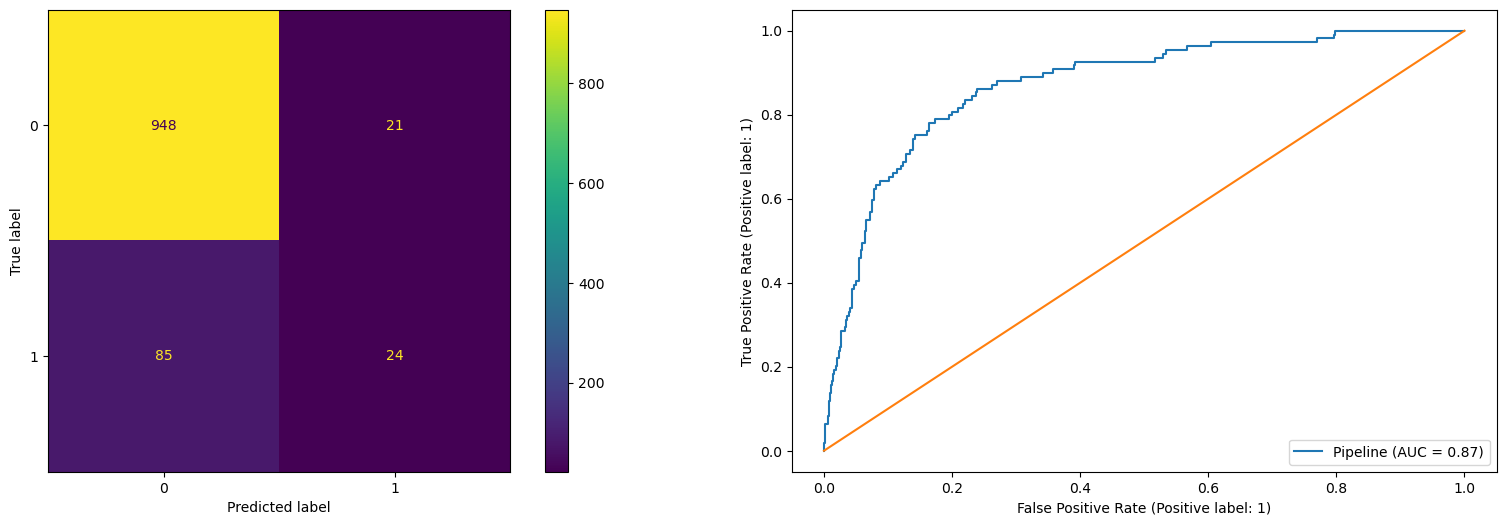

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0])  #confusion matrix and ROC chart maker
RocCurveDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

In [17]:
no_probs = lgr_pipe.predict_proba(X_test)[:, 0] #select probabilities of 'No' class
high_prob_no = no_probs[no_probs > 0.8] # those with a high probability of being no 

In [18]:
print(len(high_prob_no)/sum(y_test == 0)) #high percentage are obvious no

0.9391124871001032


In [19]:
feature_names = lgr_pipe.named_steps['transformer'].get_feature_names_out()    #what features drive the class the most
selected_features =feature_names[ [int(i[1:]) for i in lgr_pipe.named_steps['selector'].get_feature_names_out()]]
clean_names = [i.split('__')[-1] for i in selected_features]
coef_df = pd.DataFrame({'feature': clean_names, 'coefs': lgr_pipe.named_steps['lgr'].coef_[0]})
coef_df['coefs'] = coef_df['coefs'].apply(abs)
coef_df = coef_df.sort_values(by = 'coefs', ascending = False)

In [20]:
coef_df

,feature,coefs
8,duration,1.015524
4,housing,0.370281
9,campaign,0.294761
5,loan,0.244363
10,pdays,0.225390
1,education,0.189402
11,previous,0.172669
17,retired,0.170631
13,blue-collar,0.143428
14,entrepreneur,0.123483


We want to score how well the model predicts who is the most likely to subscrive to the term deposit, 
not punish too much for false positive. Will score by recall=True Positive / (True Positive + False Negative)

In [21]:
lgr_recall = 24 /(24+21)
lgr_recall

0.5333333333333333

# K-Nearest Naighbors

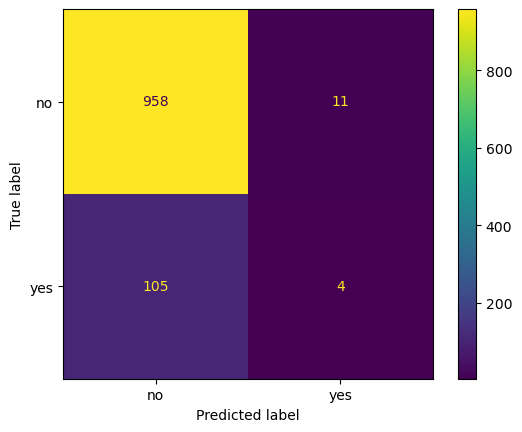

In [22]:

knn_pipe = Pipeline([('transformer', transformer), ('knn', KNeighborsClassifier(n_neighbors=10))])
knn_pipe.fit(X_train, y_train)
knn_10_recall = knn_pipe.score(X_test, y_test)
base_probs = knn_pipe.predict_proba(X_test)
preds = np.where(base_probs[:, 0] > .7)
pd.DataFrame(base_probs[:5], columns = ['p_no', 'p_yes'])
preds = knn_pipe.predict(X_test)
confusion_mat  = confusion_matrix(y_test, preds, labels=knn_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

In [23]:
min_fp = recall_score(y_test, knn_pipe.predict(X_test))#choose scoring method based on use case, precision_score(), recall_score(), accuracy_score()
recall_grid = GridSearchCV(knn_pipe, param_grid = {'knn__n_neighbors': range(1, 23, 2)},scoring = 'recall')
t0 = time.time()
recall_grid.fit(X_train, y_train)
t_knn = time.time() - t0
knn_acc = recall_grid.score(X_test, y_test)

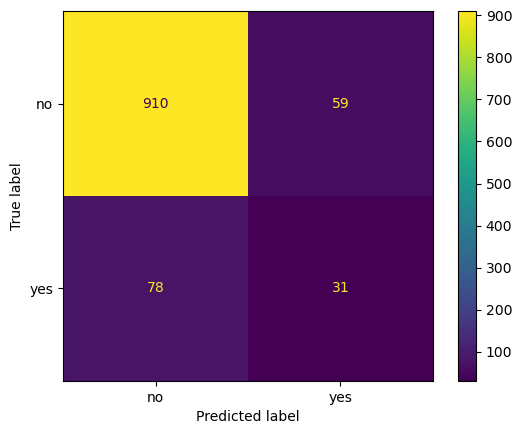

In [24]:
preds = recall_grid.predict(X_test)
confusion_mat  = confusion_matrix(y_test, preds, labels=recall_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

In [25]:
knn_recall = 31/(59+31)
knn_recall

0.34444444444444444

In [26]:
lgr_recall

0.5333333333333333

In [27]:
knn_acc = (910+31)/(910+31+78+59)

# Support vector machine

In [28]:
svc = SVC().fit(X_train, y_train) #default kernel is rbf
svc_defaults = svc.score(X_test, y_test)

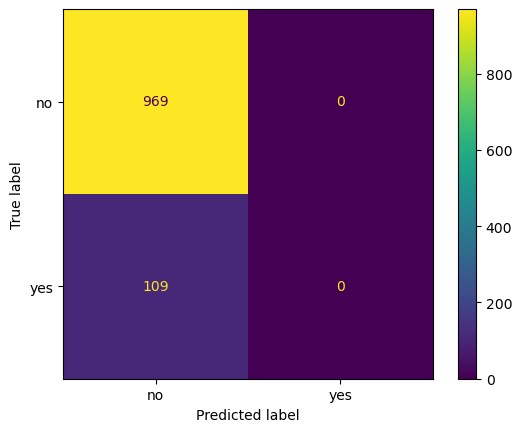

In [29]:
preds = svc.predict(X_test)
confusion_mat  = confusion_matrix(y_test, preds, labels=recall_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

In [30]:
params = {'kernel': ['rbf'], #tried each 'poly', 'linear', 'sigmoid' individuall, rbf gave best score
         'gamma': [.0001,.00001,.000001,.0000001,.0000000001],}

In [31]:
grid = GridSearchCV(svc, param_grid=params,scoring = 'recall')

In [32]:
t0 = time.time()
grid.fit(X_train, y_train)
t_svc = time.time() - t0

In [33]:
svc_acc = grid_score = grid.score(X_test, y_test)
best_kernel = grid.best_params_['kernel']
print(grid_score)
print(best_kernel)

0.09174311926605505
rbf


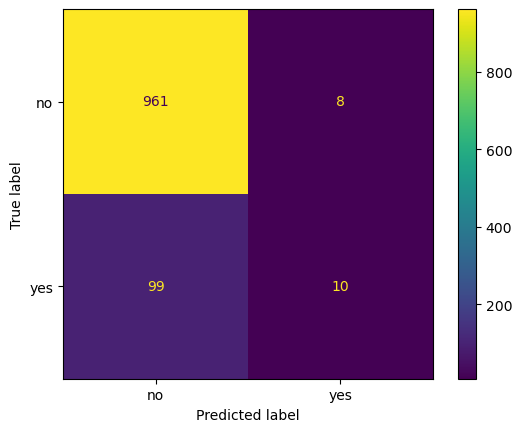

In [34]:
preds = grid.predict(X_test)
confusion_mat  = confusion_matrix(y_test, preds, labels=recall_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

In [35]:
svc_acc = grid_score
svc_recall = 8/(8+10)

# Decision Tree

In [36]:
dtree = DecisionTreeClassifier(random_state=42, min_samples_split=0.05, max_depth=5, min_impurity_decrease=0.01).fit(X_train, y_train) #edit all these parameters for best accuracy without overfitting
train_acc = dtree.score(X_train, y_train)
test_acc = dtree.score(X_test, y_test)

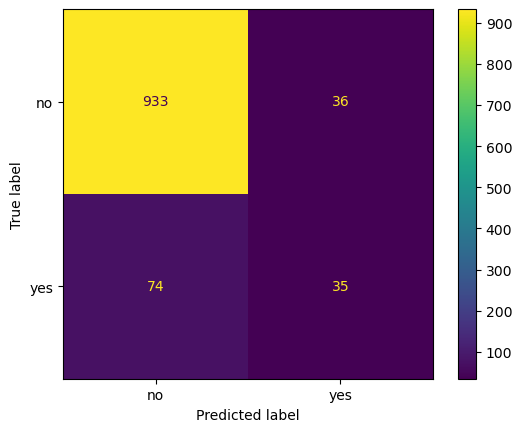

In [37]:
preds = dtree.predict(X_test)
confusion_mat  = confusion_matrix(y_test, preds, labels=recall_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

In [38]:
params = {'min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
         'max_depth': [2, 3,4,5,7, 10],
         'min_samples_split': [0.1, 0.2, 0.05]}
grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid=params,scoring = 'recall')
t0 = time.time()
grid.fit(X_train, y_train)
t_dtree = time.time() - t0
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
print(f'Training Accuracy: {grid_train_acc: .2f}')
print(f'Trest Accuracy: {grid_test_acc: .2f}')
print(f'Best parameters of tree: {best_params}')

Training Accuracy:  0.36
Trest Accuracy:  0.32
Best parameters of tree: {'max_depth': 2, 'min_impurity_decrease': 0.01, 'min_samples_split': 0.1}


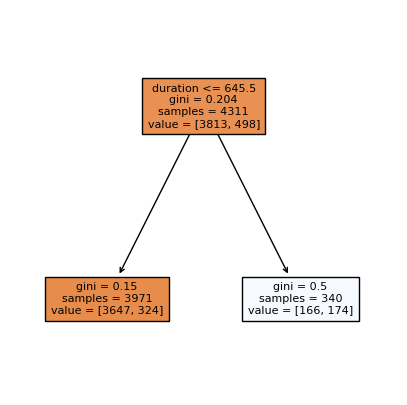

In [39]:
tree_best = DecisionTreeClassifier(max_depth = 2, min_impurity_decrease = .01 , min_samples_split = .1).fit(X, y)
fig, ax = plt.subplots(figsize = (5, 5))
plot_tree(tree_best, feature_names=list(X.columns), filled=True, ax = ax, fontsize=8);

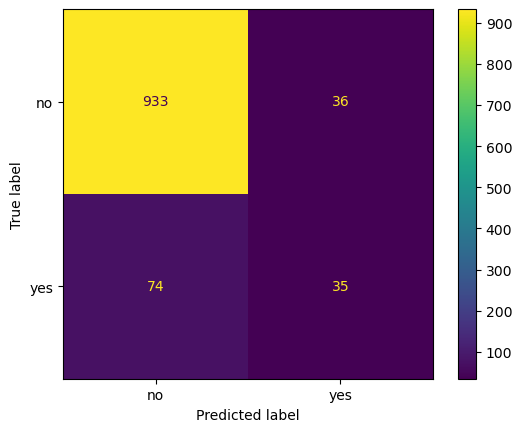

In [40]:
preds = tree_best.predict(X_test)
confusion_mat  = confusion_matrix(y_test, preds, labels=recall_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat ,display_labels = ['no', 'yes'])
disp.plot()
plt.show()

In [41]:
dtree_acc = tree_best.score(X_test, y_test)
dtree_acc
dtree_recall = 35/(35+36)

# Analysis of model performance based on use case

Pulling all of the data together from the parameter grid-searched models, we can get the dataframe below: 

In [42]:
lst = [['KNN', knn_acc,knn_recall,t_knn], ['Logistic Regression', lgr_acc,lgr_recall,t_lgr ],
       ['SVC',svc_acc,svc_recall, t_svc], ['Dtree',dtree_acc, dtree_recall, t_dtree ]]
df = pd.DataFrame(lst, columns =['model', 'Precision','recall', 'average fit time'])
df

,model,Precision,recall,average fit time
0,KNN,0.872913,0.344444,8.632777
1,Logistic Regression,0.901670,0.533333,0.093770
2,SVC,0.091743,0.444444,10.116461
3,Dtree,0.897959,0.492958,5.696604


From this data, we see that all models have similar accuracy in thier predictions, but Logistic Regression shows a higher 
recall score. Recall is a better indicatior for this use case because the data is not balanced and the idea of a false positive 
is better than a false negative. In other words, we want to know the kinds of customers that are subscribed a term deposit
and less focused on the kind of customer that is not. 

Looking into the Logistic Regression model, we can pull out which features are the most telling whether the customer is
subscribed to the term deposit by examining the weight of thier coefficents.

In [44]:
coef_df

,feature,coefs
8,duration,1.015524
4,housing,0.370281
9,campaign,0.294761
5,loan,0.244363
10,pdays,0.225390
1,education,0.189402
11,previous,0.172669
17,retired,0.170631
13,blue-collar,0.143428
14,entrepreneur,0.123483


From this useful observations can be made. the top 4 indicators of term deposit subscribers are those who: 
    1. spent a long time on the phone with a marketing rep, kind of an obvious one. 
    2. Those with housing loans
    3. Those who had been contacted multiple times by marketing reps
    4. Those with personal loans
The bottom group of indicators can also be useful: 
    1. day & month
    2. age
    3. those who defaulted on loans


From these 2 groups, several recomendations can be made to this marketing campaign. 
    1. Push the term deposit more to customers with housing loans & personal loans.
    2. Contact customers multiple times.
    3. The age of the customer has little affect on if they will sign up. 
    4. Those who have defaulted on loans are stilll open to the term deposit service. 
    5. the day and month of the call have little affect on making the sale. 